# Классификация движения фехтовальщика

In [43]:
# путь к папке fencing_signals
way_folder = 'fencing_signals/'

# пусть к папкам с записями для каждого участника
exp = ['Cherkasova_20_1/', 
       'Cherkasova_20_2/', 
       #'Sugkoeva_17/', 
       'Zushko_18/'
      ]

#частота дискритизации устройства
fs = 125

#части тела, к которым закреплены датчики
body_part = ["передней руке", "груди", "передней ноге", "задней ноге"]

#выполняемые действия
fencing_move = ['рукой', 'шагом', 'выпадом']

# сохранение графиков
save = True

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import pandas as pd
import numpy as np
import os
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import find_peaks

# Опиcание используемых функций

In [45]:
def read_data(file_names, column_names):
    """Чтение записанных данных"""
    
    dfs = []
    for file_name, column_name in zip(file_names, column_names):
        df = pd.read_csv(file_name, header=None, delimiter="\t", decimal=",", comment=";", names=[column_name])
        df_rounded = df.round(2)
        dfs.append(df_rounded)
    
    dfs_concated = []
    for i in range(4):
        df = pd.concat([dfs[i], dfs[i + 4], dfs[i + 8]], axis=1)
        dfs_concated.append(df)
    return dfs_concated

        

def creation_of_dfs(way_folder, experimental, folder):
    """Создание датафреймов с данными гироскопа по осям"""
    
    folder_path = f"{way_folder}{experimental}{folder}CSV_Export"
    file_names = ["Hyro Y_9.csv", "Hyro X_11.csv", "Hyro Z_16.csv", "Hyro X_17.csv", 
                  "Hyro X_8.csv", "Hyro Z_13.csv", "Hyro X_14.csv", "Hyro Z_19.csv",
                  "Hyro Z_10.csv", "Hyro Y_12.csv", "Hyro Y_15.csv", "Hyro Y_18.csv"]
    
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
    column_names = ["x", "x", "x", "x", "y", "y", "y", "y", "z", "z", "z", "z"]   
    dfs = read_data(file_paths, column_names)
    
    #при записи сигналов датчики были закреплены в определнных позициях, 
    #чтобы система координат для всех датчиков была одна: 
    # x вперед: 1 - вперед y, 2 - вперед x, 3 - вперед z, 4 - назад x (!изменить!)
    # y вправо: 1 - вправо x, 2 - вправо z, 3 -  влево x (!изменить!), 4 - влево z (!изменить!)
    # z вверх 1 - вверх z, 2 - вверх y, 3 - вверх y, 4 - вверх y
    
    dfs[3]['x'] = dfs[3]['x'].apply(np.negative)
    dfs[2]['y'] = dfs[2]['y'].apply(np.negative)
    dfs[3]['y'] = dfs[3]['y'].apply(np.negative)
    return dfs
    


def find_movement_peaks(dfs, move):
    """Поиск индексов начала и конца движения вперед и назад"""
    
    # Создание общего датафрейма со всеми векторами для 4 датчиков
    combined_df = pd.concat(dfs[i]['vector'] for i in range(4))
    # Суммирование значений векторов для 4 датчиков в каждый отсчет
    combined_df = combined_df.groupby(combined_df.index).agg('sum')

    # Определение параметров поиска пиков
    if move == 'Arm/':
        height_threshold = 70
        prominence_value = 50
        distance_value = 50
    elif move == 'Step/':
        height_threshold = 320
        prominence_value = 225
        distance_value = 70
    elif move == 'Lunge/':
        height_threshold = 400
        prominence_value = 380
        distance_value = 55
    else:
        raise ValueError('Unknown movement type.')

    # Нахождение пиков
    peaks, _ = find_peaks(combined_df, height=height_threshold, prominence=prominence_value, distance=distance_value)
    
    # Вычисление производной
    derivative = np.gradient(combined_df, combined_df.index)
    # Нахождение пиков производной
    positive_peaks, _ = find_peaks(derivative, distance = 15)
    negative_peaks, _ = find_peaks(-derivative, distance = 15)
    
    # Определение индексов начала и конца движений
    start_indices, end_indices = define_movement_bounds(peaks, derivative, distance_value, combined_df)

    # Разделение на движение вперед и назад
    df_forward, df_backward = separate_movements(start_indices, end_indices)

    return combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, df_forward, df_backward


def define_movement_bounds(peaks, derivative, distance_value, combined_df):
    """
    Вспомогательная функция
    Индексы начала и конца движения
    
    """
    
    midpoints = [(peaks[j - 1] + peaks[j]) // 2 for j in range(1, len(peaks))]
    start_indices = []
    end_indices = []
    window_size = distance_value // 2

    # Начало движения до первого пика
    first_peak_idx = peaks[0]
    search_start = max(0, first_peak_idx - distance_value)
    start_indices.insert(0, combined_df.index[search_start])

    # Код поиска индексов начала и конца всех движений
    for midpoint in midpoints:
        # Индекс серединной точки в исходном DataFrame
        midpoint_idx = combined_df.index.get_loc(midpoint)

        # Границы поиска в окрестности серединной точки
        search_start = max(0, midpoint_idx - window_size)
        search_end = min(len(combined_df) - 1, midpoint_idx + window_size)

        # Поиск индекса, где производная меняет знак с "+" на "-"
        for k in range(search_start + 1, search_end):
            if k < len(derivative) - 1 and derivative[k] < 0 and derivative[k - 1] >= 0:
                end_indices.append(combined_df.index[k])
                break

        # Поиск индекса, где производная меняет знак с "-" на "+"
        for l in range(search_end - 1, search_start, -1):
            if l < len(derivative) - 1 and derivative[l] > 0 and derivative[l + 1] <= 0:
                start_indices.append(combined_df.index[l])
                break

    # Конец движения после последнего пика
    last_peak_idx = peaks[-1]
    search_end = min(len(combined_df) - 1, last_peak_idx + distance_value)
    end_indices.append(combined_df.index[search_end])

    return start_indices, end_indices


def separate_movements(start_indices, end_indices):
    """
    Вспомогательная функция
    Создание датафреймов с индексами движений
    
    """
    
    # Индексы движения вперед и назад
    start_forward = start_indices[::2]
    end_forward = end_indices[::2]
    start_backward = start_indices[1::2]
    end_backward = end_indices[1::2]

    # Создание датафреймов для движений вперед и назад
    df_forward = pd.DataFrame({'start': start_forward, 'end': end_forward})
    df_backward = pd.DataFrame({'start': start_backward, 'end': end_backward})

    return df_forward, df_backward

       
     
def plot_dfs(way_folder, experimental, folder, dfs, part, body_part, start_indices = None, end_indices = None, save = False):
    """Вывод изображений"""
    
    fig = plt.figure(figsize=(20, 10))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.plot(df['t'], df['x'], color='red', label='X')
        ax.plot(df['t'], df['y'], color='blue', label='Y')
        ax.plot(df['t'], df['z'], color='darkgreen', label='Z')
        if start_indices is not None and end_indices is not None:
            for start, end in zip(start_indices, end_indices):
                plt.fill_betweenx(y=[-(df['vector'].max()), df['vector'].max()], 
                                  x1=df['t'][start], x2=df['t'][end], 
                                  color='lightgray', alpha=0.5)
            plt.vlines(x=df['t'][start_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')       
            plt.vlines(x=df['t'][end_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')
        ax.set_title(f'Сенсор закреплен на {body_part[i]}', fontsize=16)
        ax.set_ylabel('Угол, град', fontsize=12)
        ax.grid(which='major', linewidth=0.5, linestyle=':', color='k')
        ax.set_xlabel('Время, c', fontsize=12)
        ax.autoscale(enable=True, axis='both')
        plt.legend()
    fig.suptitle(f'Данные гироскопа. Движение: {part}', fontsize=20)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'{way_folder}{experimental}{folder}/{part}.png', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()
    
    
    

def plot_peaks(way_folder, experimental, folder, combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, fencing_move, i, save = False):
    """Визуализация пиков"""
    
    fig = plt.figure(figsize=(10, 4))
    plt.plot(combined_df.index, combined_df, color='grey', label = 'Сумма векторов сигнала с 4 датчиков') # сигнал по модулю с 4 датчиков
    for start, end in zip(start_indices, end_indices):
        plt.fill_betweenx(y=[combined_df.min(), combined_df.max()],
                          x1=combined_df.index[start], x2=combined_df.index[end], color='lightgray', alpha=0.5)
    plt.vlines(x=combined_df.index[start_indices], ymin=combined_df.min(), ymax=combined_df.max(), color='green')       
    plt.vlines(x=combined_df.index[end_indices], ymin=combined_df.min(), ymax=combined_df.max(), color='green')       
    plt.plot(combined_df.index[positive_peaks], derivative[positive_peaks], color = 'orange', label = 'Производная')
    plt.plot(combined_df.index[negative_peaks], derivative[negative_peaks], color = 'orange')
    plt.plot(peaks, combined_df[peaks], "x", ms=10, mew=2, label = 'Пик')
    plt.ylabel('Угол, град', fontsize=10)
    plt.xlabel('Время, c', fontsize=10)
    plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
    plt.autoscale(enable=True, axis='both')
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title(f'Данные гироскопа. Движение: {fencing_move[i]}', fontsize=12)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'{way_folder}{experimental}{folder}/{fencing_move[i]}.png', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()
    

def movement(dfs, start, end):
    """Разделение сигнала на отдельные движения"""
    
    movement_dfs = []
    for df in dfs:
        movement_dfs.append(df[['x', 'y', 'z', 't']][start:end])
    return movement_dfs



def features(dfs, part, body_part, experimental):
    """Определение характеристик и вывод их в отдельный датафрейм"""
    
    # Словарь для перевода названий статистик
    translation_dict = {
        'count': 'Отсчеты',
        'mean': 'Среднее',
        'std': 'Стандартное отклонение',
        'min': 'Минимум',
        '25%': '25-й процентиль',
        '50%': 'Медиана',
        '75%': '75-й процентиль',
        'max': 'Максимум'
    }

    features_df = []
    for df in dfs:
        
        # Создание датафрейма со статистическими характеристиками 
        feature_df = ((df.iloc[:, :3].describe()).round(1)).T.rename(columns=translation_dict)

        # Добавление маркеров
        feature_df['Класс'] = ' '.join(part.split()[:2])
        feature_df['Фехтовальщик'] = experimental
        
        features_df.append(feature_df)

    # Объединанение датафреймов в один
    combined_df = pd.concat(features_df)
    combined_df = combined_df.groupby('Класс').agg(lambda x: x.sum() if x.name not in ['Отсчеты', 'Класс', 'Фехтовальщик'] else x.iloc[0])
    return combined_df


def evaluate_preds(true_values, train_true_values, pred_values, train_pred_values, labels, save=False):
    """Оценка качества модели и график предсказанные и фактические значения"""
    
    plt.figure(figsize=(8,5))
    plt.scatter(unique_movements, unique_movements, color='white', s = 1) 
    plt.xlabel('Предсказанные значения', fontsize=14)
    plt.ylabel('Фактические значения', fontsize=14)
    plt.title('Фактические и предсказанные значения', fontsize=16)
    plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.margins(x=0.1, y=0.1)

    # Подсчет количества точек с одинаковыми координатами для тренировочных данных
    point_counts_train = {}
    for x, y in zip(train_pred_values, train_true_values):
        point_counts_train[(x, y)] = point_counts_train.get((x, y), 0) + 1
    for (x, y), count in point_counts_train.items():
        size = 20 * count
        plt.scatter(x, y, color='red', s=size)
        offset = np.sqrt(size) / 4
        plt.annotate(f' ({count})', xy=(x, y), xytext=(offset, -offset),
                     textcoords='offset points', fontsize=8, color='red', ha='left', va='top')
        
    # Подсчет количества точек с одинаковыми координатами для тестовых данных
    point_counts_test = {}
    for x, y in zip(pred_values, true_values):
        point_counts_test[(x, y)] = point_counts_test.get((x, y), 0) + 1
    for (x, y), count in point_counts_test.items():
        size = 20 * count
        plt.scatter(x, y, color='green', s=size)
        offset = np.sqrt(size) / 2
        plt.annotate(f' {count}', xy=(x, y), xytext=(offset, offset),
                     textcoords='offset points', fontsize=8, color='green')
    
    
    rect = patches.FancyBboxPatch((0.15, 0.705), 0.27, 0.095, 
                                  boxstyle="round,pad=0.01", 
                                  facecolor='whitesmoke', alpha=0.5,
                                  edgecolor='black', 
                                  transform=plt.gcf().transFigure)
    plt.gca().add_patch(rect)
    plt.annotate('Количество точек:', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.875), xycoords='axes fraction', fontsize=10, color='black')
    plt.annotate('• 1 - тестовая выборка', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.825), xycoords='axes fraction', fontsize=10, color='green')
    plt.annotate('• (1) - тренировочная выборка', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.775), xycoords='axes fraction', fontsize=10, color='red')

    if save == True:
        plt.savefig(f'Фактические и предсказанные значения.png', dpi=400, bbox_inches='tight')
    plt.show()

# Просмотрим и проанализируем данные

In [46]:
# название папок с движениями
moves = ['Arm/', 'Step/', 'Lunge/']

for experimental in exp:
    for i, move in enumerate(moves):

        dfs = creation_of_dfs(way_folder, experimental, move)

        # Создание отсчета времени, используя частоту дискретизации устройства
        t = np.arange(len(dfs[0]['x'])) / fs
        for df in dfs:
            df['t'] = t
            

        """ Для вывода всех сигналов снять # """
#         plot_dfs(way_folder, experimental, move, dfs, fencing_move[i], body_part, save = save)

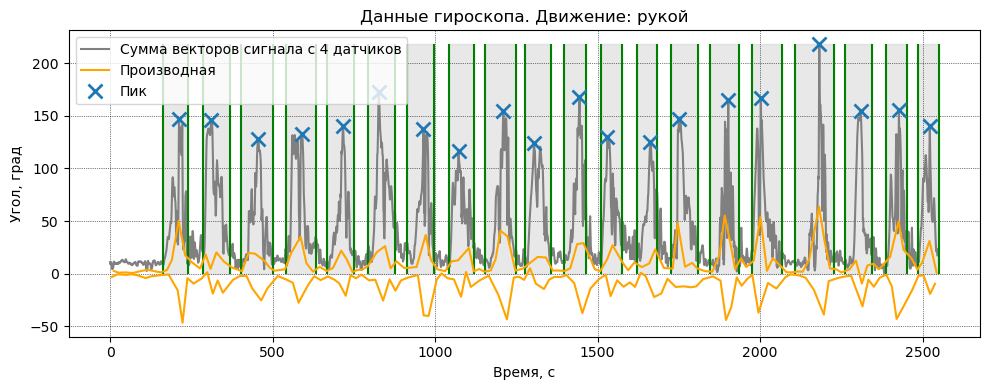

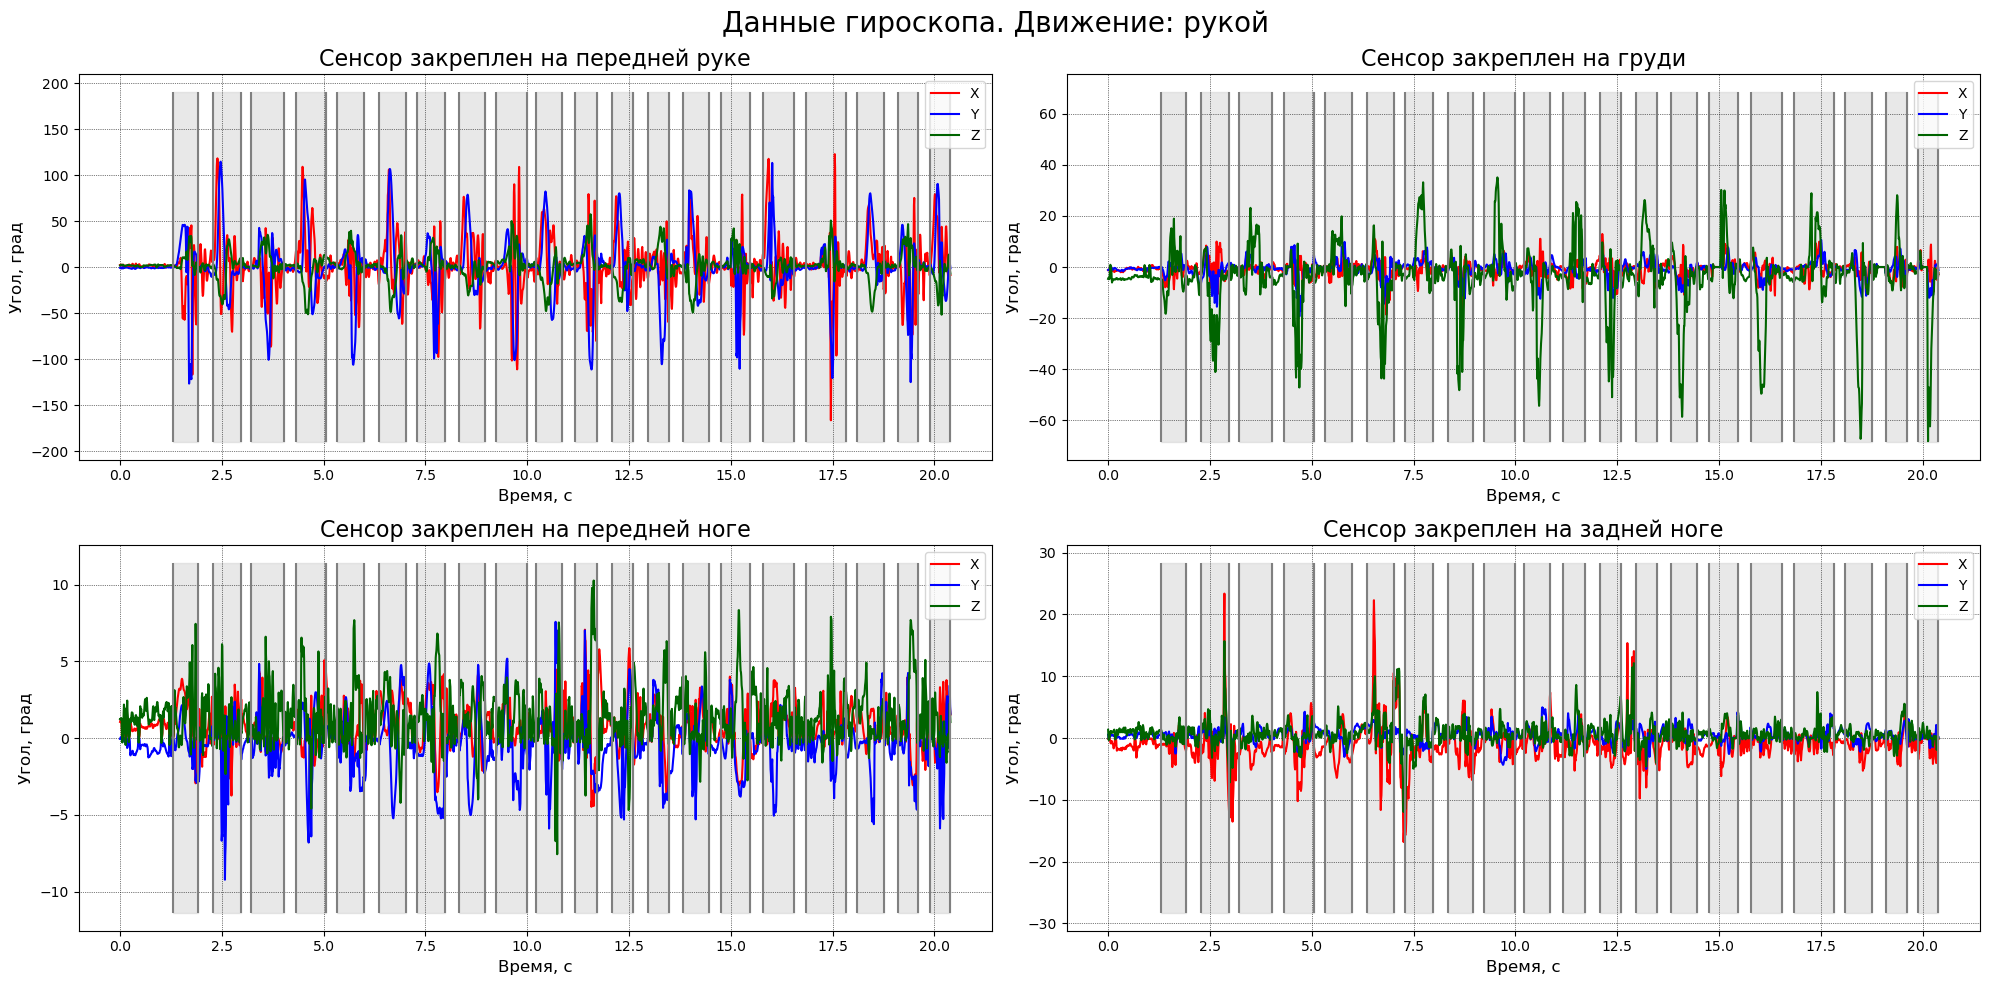

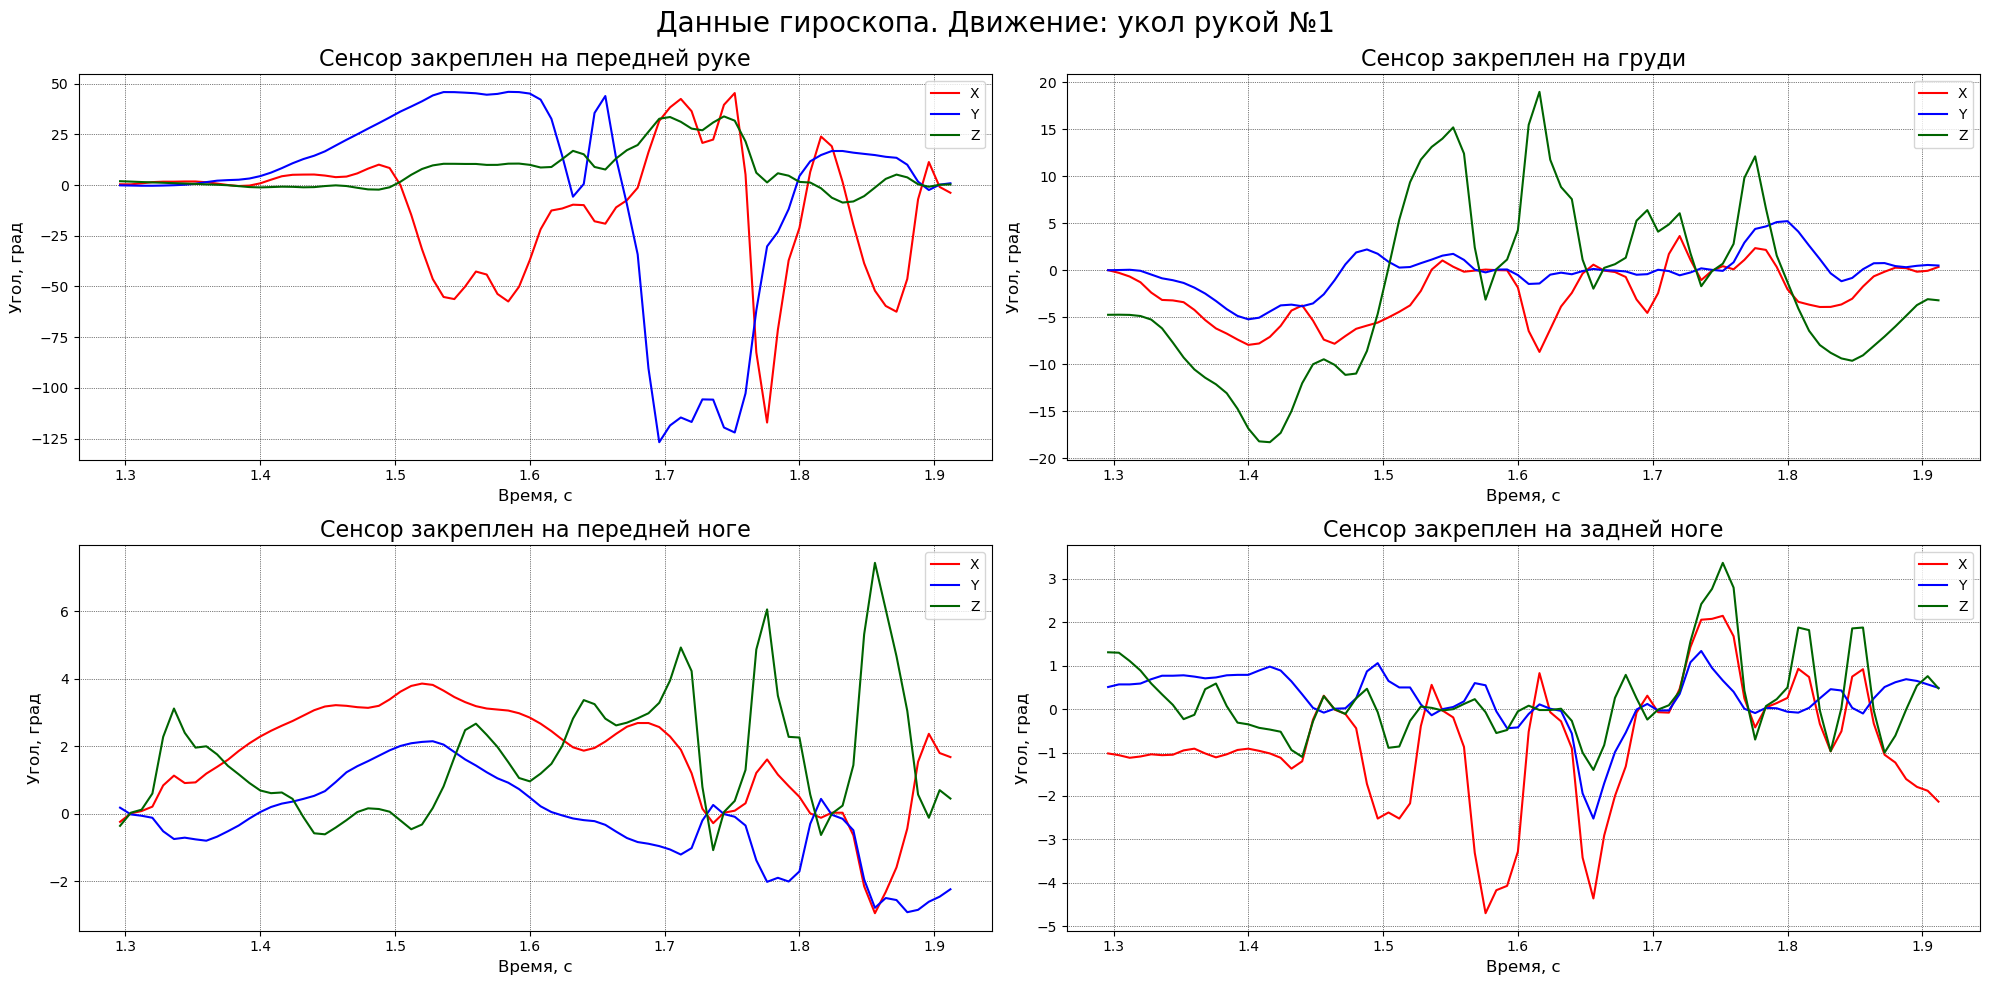

In [47]:
# название папок с движениями
moves = ['Arm/', 'Step/', 'Lunge/']
ways = ['укол', 'закрытие']
all_movement_dfs = []
all_params = []
peaks_executed = False
action_executed = False

for experimental in exp:
    for i, move in enumerate(moves):

        dfs = creation_of_dfs(way_folder, experimental, move)

        # Создание отсчета времени, используя частоту дискретизации устройства
        # Создание вектора по евклидовой норме
        t = np.arange(len(dfs[0]['x'])) / fs
        for df in dfs:
            df['t'] = t
            df['vector'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
            
        # Сигнал при движении рукой имеет в конце сильный скачок, поэтому наобходимо обрезать сигнал
        if move == 'Arm/' and experimental == 'Cherkasova_20_1/':
            for df in dfs:
                df.drop(index=range(2550, len(df)), inplace=True)
                
        combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, df_forward_ind, df_backward_ind = find_movement_peaks(dfs, move)
        if not peaks_executed:
            plot_peaks(way_folder, experimental, move, combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, fencing_move, i, save = save)
            plot_dfs(way_folder, experimental, move, dfs, fencing_move[i], body_part, start_indices, end_indices, save = save)
            peaks_executed = True
            
        """Для вывода всех пиков снять # """
#         plot_peaks(way_folder, experimental, move, combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, fencing_move, i, save = save)
#         plot_dfs(way_folder, experimental, move, dfs, fencing_move[i], body_part, start_indices, end_indices, save = save)
            
        # Разделение сигнала на отдельные движения и подсчет параметров для характеристики движения
        for n, df in enumerate([df_forward_ind, df_backward_ind]):
            for a in range(len(df)):
                movement_dfs = movement(dfs, df['start'][a], df['end'][a])
                all_movement_dfs.append(movement_dfs)
                #Для примера. Вывод графика одного движения и данные датчиков к нему
                if not action_executed:
                    plot_dfs(way_folder, experimental, move, movement_dfs, f'{ways[n]} {fencing_move[i]} №{a+1}', body_part, save = save)
                    action_executed = True
                    
                """Для вывода всех движений снять # """
#                 plot_dfs(way_folder, experimental, move, movement_dfs, f'{ways[n]} {fencing_move[i]} №{a+1}', body_part, save = save)
                    
                params = features(movement_dfs, f'{ways[n]} {fencing_move[i]} №{a+1}', body_part, experimental)
                all_params.append(params)

# Объединение датафреймов в один 
A = pd.concat(all_params)

# Обработаем данные

### Cозданный общий датафрейм содержит в себе данные о всех сделанных движениях во время исследования, а также их параметры

In [48]:
print('Количество сделанных движений, количество параметров для 1 движения: ', A.shape)
A.sample(6)

Количество сделанных движений, количество параметров для 1 движения:  (294, 9)


,Отсчеты,Среднее,Стандартное отклонение,Минимум,25-й процентиль,Медиана,75-й процентиль,Максимум,Фехтовальщик
Класс,,,,,,,,,
закрытие шагом,65.0,-27.8,520.0,-1244.4,-282.6,-26.9,176.7,1256.6,Zushko_18/
укол рукой,55.0,-9.5,122.3,-306.9,-86.7,11.0,72.6,212.8,Cherkasova_20_2/
укол шагом,39.0,-11.2,306.9,-689.7,-175.5,1.5,136.8,664.7,Cherkasova_20_2/
закрытие шагом,40.0,-54.3,382.3,-889.0,-232.8,-44.9,144.6,805.9,Cherkasova_20_2/
закрытие выпадом,70.0,-69.1,751.4,-1476.7,-595.0,-51.8,433.1,1559.7,Cherkasova_20_2/
закрытие выпадом,171.0,-27.6,403.7,-989.2,-148.3,31.8,164.1,1081.7,Cherkasova_20_1/


### Классы движений

In [49]:
unique_movements = A.index.unique().tolist()
unique_movements

['укол рукой',
 'закрытие рукой',
 'укол шагом',
 'закрытие шагом',
 'укол выпадом',
 'закрытие выпадом']

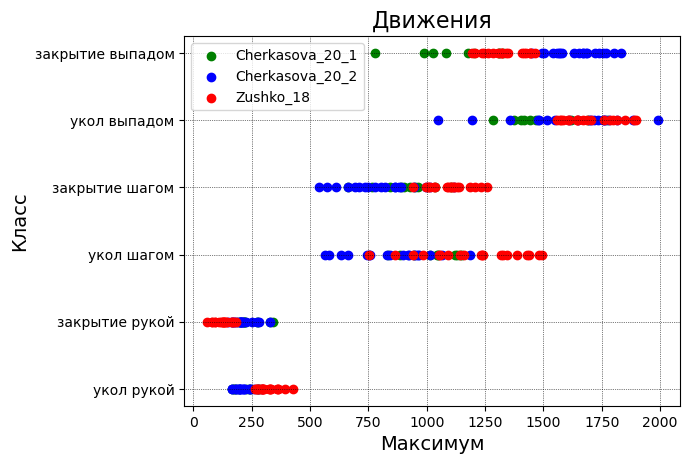

In [50]:
plt.figure()
prm = ['Отсчеты', 'Среднее', 'Стандартное отклонение', 'Минимум', '25-й процентиль', 'Медиана', '75-й процентиль', 'Максимум']
prmNum = 7
colors = ['green', 'blue', 'red', 'orange']
for i, color in zip(range(len(exp)), colors):
    Ai = A[A['Фехтовальщик'] == exp[i]]
    plt.scatter(Ai[prm[prmNum]].tolist(), Ai.index.tolist(), color=color, label=exp[i][:-1]) 
plt.xlabel(prm[prmNum], fontsize=14)
plt.ylabel('Класс', fontsize=14)
plt.title('Движения', fontsize=16)
plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
plt.legend()
plt.savefig(f'Движения.png', dpi=400, bbox_inches='tight')
plt.show()

In [51]:
A = A.drop('Фехтовальщик', axis = 1)

# Решаем задачу классификации с учителем 

In [52]:
y = pd.DataFrame(A.index) # Целевая переменная
X = A.reset_index(drop=True)  # Матрица признаков

feature_names = ['Отсчеты',
                 'Среднее',
                 'Стандартное отклонение',
                 'Минимум',
                 '25-й процентиль',
                 'Медиана',
                 '75-й процентиль',
                 'Максимум']

In [53]:
X.head()

,Отсчеты,Среднее,Стандартное отклонение,Минимум,25-й процентиль,Медиана,75-й процентиль,Максимум
0,78.0,-7.9,110.0,-300.1,-46.0,7.9,54.9,173.2
1,100.0,-6.2,92.0,-230.5,-36.5,1.7,48.1,174.8
2,83.0,-2.6,97.1,-222.0,-35.4,11.2,56.0,163.9
3,86.0,0.2,102.9,-264.2,-35.0,3.8,60.7,195.1
4,95.0,-1.2,118.8,-263.8,-37.1,5.9,42.3,271.6


In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Отсчеты                 294 non-null    float64
 1   Среднее                 294 non-null    float64
 2   Стандартное отклонение  294 non-null    float64
 3   Минимум                 294 non-null    float64
 4   25-й процентиль         294 non-null    float64
 5   Медиана                 294 non-null    float64
 6   75-й процентиль         294 non-null    float64
 7   Максимум                294 non-null    float64
dtypes: float64(8)
memory usage: 18.5 KB


In [55]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Класс   294 non-null    object
dtypes: object(1)
memory usage: 2.4+ KB


In [56]:
y.sample(5)

,Класс
34,закрытие шагом
53,закрытие выпадом
158,закрытие выпадом
108,укол шагом
140,укол выпадом


### Рандомизируем выборку и разделим на тренировочную и тестовую выборки

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=9)

### Стандартизируем признаки

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Решим задачу классификации методом логистической регрессии

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Создание модели логистической регрессии
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Обучение модели на обучающей выборке
lr.fit(X_train, y_train)

# Прогнозирование классов для тестовых данных
y_pred = lr.predict(X_test)

# Прогнозирование классов для тренировочных данных
y_train_pred = lr.predict(X_train)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.8775510204081632


In [60]:
print(classification_report(y_test, y_pred, target_names=unique_movements, digits=4))

                  precision    recall  f1-score   support

      укол рукой     0.9412    0.8889    0.9143        18
  закрытие рукой     0.8750    0.7778    0.8235        18
      укол шагом     0.9286    0.8125    0.8667        16
  закрытие шагом     0.9286    0.9286    0.9286        14
    укол выпадом     0.7647    0.8667    0.8125        15
закрытие выпадом     0.8500    1.0000    0.9189        17

        accuracy                         0.8776        98
       macro avg     0.8813    0.8791    0.8774        98
    weighted avg     0.8823    0.8776    0.8771        98



In [61]:
check_test = pd.DataFrame({
    'Фактическое': y_test['Класс'],
    'Предсказанное': y_pred.flatten(),
})

check_test.sample(10)

,Фактическое,Предсказанное
254,закрытие шагом,закрытие шагом
156,закрытие выпадом,закрытие выпадом
204,закрытие рукой,закрытие рукой
270,укол выпадом,укол выпадом
100,укол шагом,укол шагом
259,укол выпадом,укол выпадом
54,закрытие выпадом,закрытие выпадом
206,закрытие рукой,закрытие рукой
212,закрытие рукой,закрытие рукой
267,укол выпадом,укол выпадом


# График сравнения фактических и предсказанных значений

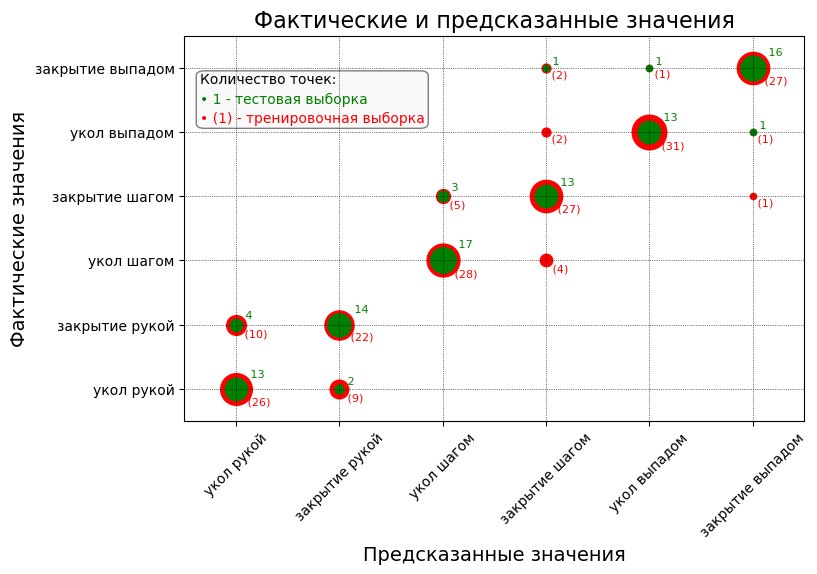

In [62]:
evaluate_preds(y_test['Класс'].tolist(), y_train['Класс'].tolist(), y_pred.tolist(), y_train_pred.tolist(), unique_movements, save = save)